<a href="https://colab.research.google.com/github/jaepillee0315/36705-Intermediate-Stat/blob/master/Recitation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from sklearn.preprocessing import PolynomialFeatures
import time
from scipy.stats import lognorm
from statsmodels.nonparametric.kernel_regression import KernelReg

In [0]:
change_mile = np.load('change_mile.npy')
X = np.load('mileage.npy')
y = np.load('decision.npy')

**Harold Zurcher Problem**
  * Action set $\mathcal{J}$:
    * $j = 0$: change the bus engine
    * $j = 1$: do not change the bus engine
  * State space $\mathcal{X}$:
    * $x \in \mathbb{R_{+}}$: accumulated miles on the bus engine
  * Stochastic dynamics of the state space $F(x'|x,j)$, $j \in \mathcal{J}$ and $x,x' \in \mathcal{X}$
    * $x'$ represents the next period bus mileage given: \\
    1) the current mileage $x$ \\
    2) Harold Zurcher action $j$

We can write the value function condtional on the choice $j \in \lbrace 0,1\rbrace$:
\begin{align*}
v_0(x) & = u_0(x) + \beta \int_{0}^{\infty} V(x')f(x'|x,0)dx' \\
v_1(x) & = u_1(x) + \beta \int_{x}^{\infty} V(x')f(x'|x,1)dx'
\end{align*}
We can express the continuation value $V(x')$ as a function of the value functions conditional the action $j$:
\begin{align*}
  V(x') & = \mathbb{E}_{\varepsilon}\left[ \max_{j \in \mathcal{J}} v_{j}(x')+\varepsilon_j \right] \\
  & = \gamma + \log( \exp(v_0(x')) + \exp(v_1(x')))
\end{align*}
given our assumptions about the distribution of the error terms. In particular, we have assumed that the errors follow a Type-1 Extreme Value distribution, and we have exploited the following properties:
  * $X \sim EV(\mu,1)$, $a \in \mathbb{R}$, then $X+a \sim EV(\mu,1)$
  * $X \sim EV(\mu_x,1)$, $Y \sim EV(\mu_y,1)$, then $\max(X,Y) \sim EV(\log(\exp(\mu_x)+\exp(\mu_y)),1)$
 
 
We can replace the above expression above and write for action $j=0$:
\begin{align*}
v_0(x) & = u_0(x) +  \beta \int_{0}^{\infty} \left[ \gamma + v_0(x') + \log \left(1+\exp\left(v_0(x')-v_1(x')\right)\right)\right] f(x'|x,0)dx' \\
& = u_0(x) + \beta \int_{0}^{\infty} \left[ \gamma + u_0(x') + \beta \int_{0}^{+\infty} V(x'')f(x''|x',0)  dx'' + \log \left(1+\exp\left(v_1(x')-v_0(x')\right)\right)\right] f(x'|x,0)dx'
\end{align*}

Similarly, we have for action $j=1$ we have:
\begin{align*}
v_1(x) & = u_1(x) +  \beta \int_{x}^{\infty} \left[ \gamma + v_0(x') + \log \left(1+\exp\left(v_1(x')-v_0(x')\right)\right)\right] f(x'|x,1)dx' \\
& = u_1(x) + \beta \int_{x}^{\infty} \left[ \gamma + u_0(x') + \beta \int_{0}^{+\infty} V(x'')f(x''|x',0)  dx'' + \log \left(1+\exp\left(v_1(x')-v_0(x')\right)\right)\right] f(x'|x,1)dx'
\end{align*}

We have shown in class that:
\begin{align*}
V(x) & = v_{j}(x) + \gamma - \log P(d=j|x) \ \ \forall j\in \lbrace 0,1\rbrace, \forall x \in \mathcal{X}
\end{align*}
and therefore, we can replace $v_1(x')-v_0(x')$ in the integrals computed above
\begin{align*}
v_1(x')-v_0(x') & = \log P(d=1|x)- \log P(d=0|x) \\
                & = \log \left( \frac{P(d=1|x)}{ P(d=0|x)}  \right)
\end{align*}
by simply rerraning the equation above. 
Now, we can rewrite:
\begin{align*}
\log \left(1+\exp\left(v_1(x')-v_0(x')\right) \right)& = \log\left(1 + \frac{P(d=1|x)}{ P(d=0|x)} \right) \\
& = \log\left(\frac{P(d=0|x)+P(d=1|x)}{ P(d=0|x)} \right) \\
& = \log\left(\frac{1}{ P(d=0|x)} \right) \\
& = - \log\left({P(d=0|x)} \right) \\
\end{align*}



\begin{align*}
v_0(x) & = u_0(x) + \beta \int_{0}^{\infty} \left[ \gamma + u_0(x') + \beta \int_{0}^{+\infty} V(x'')f(x''|x',0)  dx'' - \log P(d=0|x')\right] f(x'|x,0)dx' \\
v_1(x) &  = u_1(x) + \beta \int_{x}^{\infty} \left[ \gamma + u_0(x') + \beta \int_{0}^{+\infty} V(x'')f(x''|x',0)  dx'' -\log P(d=0|x')  \right] f(x'|x,1)dx'
\end{align*}
What do the two expression have in common? We can exploit fact that $f(x''|x',0)$ does not depend on $x'$:
\begin{align*}
\int_{0}^{\infty} \left[ \gamma + \beta \int_{0}^{+\infty} V(x'')f(x''|x',0) \right] dx'' f(x'|x,0)dx' = \int_{x}^{\infty} \left[ \gamma + \beta \int_{0}^{+\infty} V(x'')f(x''|x',0) \right] dx'' f(x'|x,1)dx' \\
\int_{0}^{\infty} \left[ \gamma + \beta \int_{0}^{+\infty} V(x'')f(x''|0) \right] dx'' f(x'|x,0)dx' = \int_{x}^{\infty} \left[ \gamma + \beta \int_{0}^{+\infty} V(x'')f(x''|0) \right] dx'' f(x'|x,1)dx'
\end{align*}
to simplify the two equations for the conditional value functions:
\begin{align*}
v_0(x) & = u_0(x) + \beta \int_{0}^\infty \left[u_0(x') - \log\left(P(d=0|x')\right) \right] f(x'|x,0)dx' \\
v_1(x) & = u_1(x) + \beta \int_{x}^\infty \left[u_0(x') - \log\left(P(d=0|x')\right) \right] f(x'|x,1)dx'
\end{align*}
Now, a convenient but not innocuous assumption is that $u_0(x)=\theta_0 \ \ \forall x \in \mathcal{X}$. In this particular case, we have clearly that:
\begin{align*}
  \int_{0}^\infty  u_0(x') f(x'|x,0) dx'=  \int_{x}^\infty u_0(x') f(x'|x,1) dx'
\end{align*} 
so we can lose another piece:
\begin{align*}
v_0(x) & = u_0(x) + \beta \int_{0}^\infty \left[ - \log\left(P(d=0|x')\right) \right] f(x'|x,0)dx' \\
v_1(x) & = u_1(x) + \beta \int_{x}^\infty \left[- \log\left(P(d=0|x')\right) \right] f(x'|x,1)dx'
\end{align*}
Now, it is the time to make the structural estimation assumption, i.e. to clearly point out which are the primitives that characterize the utility. We have already assume that $u_0(x)=\theta_0$ is a constant, and now we assume that $u_1(x)=\theta_1 x + \theta_2 x^2$. Clearly, the assumptions made here, i.e. the functional form of the utility function are an educated guess of the researcher. 
\begin{align*}
v_0(x) & = \theta_0 + \beta \int_{0}^\infty \left[ - \log\left(P(d=0|x')\right) \right] f(x'|x,0)dx' \\
v_1(x) & = \theta_1 x + \theta_2 x^2 + \beta \int_{x}^\infty \left[- \log\left(P(d=0|x')\right) \right] f(x'|x,1)dx'
\end{align*}



Keep in mind that we have already estimated: 
* the transition probabilities$f(x'|x,1)$, $f(x'|x,0)$ $\forall x, x' \in \mathcal{X}$ 
* the CCPs $P(d=0|x')$
In this way, we can replace the empirical analogues. Keep in mind that by assumption about the Type-1 errors:
\begin{align*}
P(d=1|x) & = Pr(v_1(x)+\varepsilon_1 \geq v_0(x)+\varepsilon_0) \\
        & = \frac{\exp(v_1(x))}{\exp(v_1(x)) + \exp(v_0(x))} \\
        & = \frac{\exp(v_1(x)-v_0(x))}{1 + \exp(v_1(x)-v_0(x))}
\end{align*}
We can now express $P(d=1|x)$ as a function of:
* the estimates performed in the first stage
* the structural parameters $\theta_0,\theta_1,\theta_2$
In this case, we have that:
\begin{align*}
  v_1(x)-v_0(x) = \theta_1 x + \theta_2 x^2 - \theta_0 + \beta \left( \int_{0}^\infty \left(f(x'|x,1)-f(x'|x,0)\right)[-\log P(d=0|x')] dx'  \right)
\end{align*}
Now, let define:
\begin{align*}
 \hat{h}(x) & = \beta \left( \int_{0}^\infty \left(\hat{f}(x'|x,1)-\hat{f}(x'|x,0)[-\log \hat{P}(d=0|x')]\right) dx'  \right)
\end{align*}
Keep in mind that given that we have made paremetric assumptions about the utility function, we can now estimate also the discount factor $\beta$
Now, by maximum likelihood we can estimate:
\begin{align*}
\mathcal{L}(\theta_0,\theta_1,\theta_2,\beta|y,X) & = \prod_{i=1}^N \prod_{t=1}^T \prod_{j=0}^1 P(d_{it}=j)^{d_{it}=j} \\
& = \prod_{i=1}^N \prod_{t=1}^T \left(\frac{\exp(\theta_1 x_{it} + \theta_2 x_{it}^2 -\theta_0 + \beta \hat{h}(x_{it}))}{1+\exp(\theta_1 x_{it} + \theta_2 x_{it}^2 -\theta_0 + \beta \hat{h}(x_{it}))}\right)^{d_{it}=1} \left(\frac{1}{1+\exp(\theta_1 x_{it} + \theta_2 x_{it}^2 -\theta_0 + \beta \hat{h}(x_{it}))}\right)^{d_{it}=0}
\end{align*}


We have established the elements that characterize Harold Zurcher problem. We now need to estimate:
  * transition probabilities, $F(x'|x,j)$ for each action in the action set $\mathcal{J}$
  * conditional choice probabilities $Pr(d=j|x)$

**Estimation of the Transition Probabilities** \\
First of all, we take a look at the histogram representing the distribution of the monthly change in the mileage of buses $x'-x=\Delta x$, conditional on Harold Zuercher having decided to not change the engine (i.e. for $j=1$), but unconditionally on miles previously accumulated $x$.

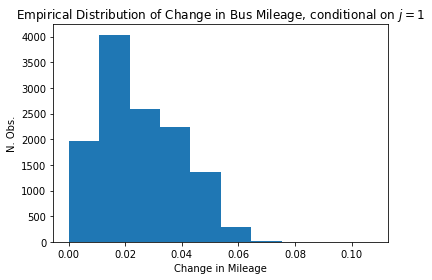

In [0]:
plt.figure()
plt.hist(change_mile)
plt.xlabel('Change in Mileage')
plt.ylabel('N. Obs.')
plt.title('Empirical Distribution of Change in Bus Mileage, conditional on $j=1$')
plt.show()

We can observe that the change in the bus mileage is upper-bounded by 0.10, which tells us that in the data, we do not observe any bus running more than 10 thousands miles in a month. What does this suggest? In order to estimate the transition probabilities, we should probably stick to probabilities distributions that either:
  * are discrete;
  * have a bounded support.

For simplicity, we choose the distribution to be discrete, and we impose the following (empirically guided) restriction:
\begin{align*}
Pr(x'-x = \Delta x ) > 0 \ \  \mbox{iff.} \ \ \Delta x  \in [0,0.10] 
\end{align*}

Now, what we have represented above is the empirical version $F(\Delta x|j)$, that is something a bit different from the object we represented above, i.e. $F(x'|x,j)$. The next question we need to answer is whether we can approximate $F(\Delta x |x,j)$ with $F(\Delta x|j)$, that, if the distance traveled by a bus does not depend on the previously accumulated mileage $x$. 

One possible way to see whether the accumulated mileage $x$ is somewhat correlated with the future distance run by the bus $\Delta x$. To do this, we run a simple OLS regression:
\begin{align*}
  \Delta  x_{it} & = \beta_0 + \beta_1 x_{it} + \varepsilon_{it}
\end{align*}
where $i$ denotes the bus and $t$ denotes the time. $\beta_0$ represents the average distance run by a bus in a certain month, whike $\beta_1$ represents the marginal effect of an additional accumulated mile on the distance run by the bus. 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.188
Date:                Fri, 14 Feb 2020   Prob (F-statistic):              0.139
Time:                        00:07:53   Log-Likelihood:                 35454.
No. Observations:               12472   AIC:                        -7.090e+04
Df Residuals:                   12470   BIC:                        -7.089e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0254      0.000    113.460      0.0

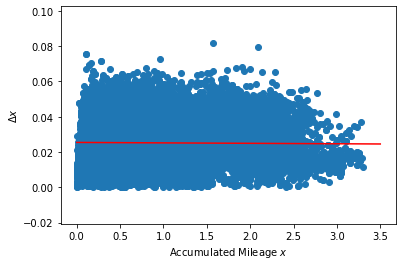

In [0]:
X_temp = np.c_[X[1:]-X[:-1],X[1:]]
X_temp = X_temp[X_temp[:,0]>0.0001,:]
X_temp = X_temp[X_temp[:,0]<0.1,:]
X_temp = X_temp[X_temp[:,1]>0,:]

mod = sm.OLS(X_temp[:,0],sm.add_constant(X_temp[:,1]))
res = mod.fit()
print(res.summary())

plt.figure()
plt.plot()
plt.scatter(X_temp[:,1],X_temp[:,0])
x = np.linspace(0,3.5,100)
plt.plot(x,x * res.params[1] + res.params[0],color='r')
plt.xlabel('Accumulated Mileage $x$')
plt.ylabel('$\Delta x$')
plt.show()



The estimated $\hat{\beta}_1$ is very small, and from the picture above, it barely changes the expected distance traveled by a bus. Therefore, we can safely assume that transition probability depends only the action taken, and not on the state. Below we estimate the probability distribution under the assumptions that we have derived so far:
  * discrete and bounded support
  * independent on the accumulated mileage $x$

We divide the interval $[0,0.1]$ into 20 subintervals (each of them corresponding 500 miles), and we compute the empirical distribution as follows:
\begin{align*}
 \hat{Pr}(x'-x \in [\Delta x_{j-1},\Delta x_{j}]) & = \frac{1}{nT} \sum_{t=1}^T \sum_{i=1}^n \frac { \mathbb{1} (\Delta x_{j-1} \leq \Delta x_{it}\leq \Delta x_{j}) }{nT} \ \ \ j=1,\cdots,20
\end{align*}

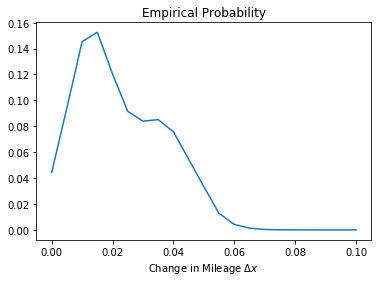

In [0]:
N_t = 20
thresholds = np.r_[np.linspace(0,.1,N_t+1),[1]]
phat = np.zeros((len(thresholds)-1,))

for i in range(N_t):
  phat[i] = len(change_mile[np.all([change_mile >= thresholds[i], change_mile < thresholds[i+1]], axis=0)])/len(change_mile)

plt.figure()
plt.plot(thresholds[:-1],phat)
plt.xlabel('Change in Mileage $\Delta x$')
plt.title('Empirical Probability')
plt.show()


**Estimation of the Conditional Choice Probabilities**

We can now focus on the estimation of the conditional choice probabilities. In this case, the state space is continuous, and we have two natural choices:
  * discretize the state space, and compute the conditional choice probability for each cell
  * treat the state space as continuous, and use a non-parametric regression

In this case, we have more than 13000 observation, so we do not need to aggregate up observations into cells, although the distribution of the accumulated mileage do not look uniform:

In [0]:
kr = KernelReg(y, X, var_type='c', reg_type='lc')

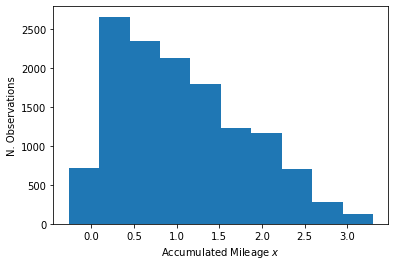

In [0]:
plt.figure()
plt.hist(X)
plt.xlabel('Accumulated Mileage $x$')
plt.ylabel('N. Observations')
plt.show()

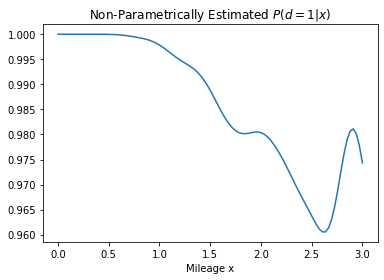

In [0]:
x = np.linspace(0,3,100)
y_hat = kr.fit(x)
plt.figure()
plt.plot(x,y_hat[0])
plt.xlabel('Mileage x')
plt.ylabel('')
plt.title('Non-Parametrically Estimated $P(d=1|x)$')
plt.show()

In [0]:
X_train = X[X[:]>0]
y_train = y[X[:]>0]

X_tile = np.tile(X_train,(N_t+1,1)).T
Delta = np.tile(thresholds[:-1]+0.0025,(X_tile.shape[0],1))
X_prime = X_tile + Delta
p0_hat_1 = 1 - np.reshape(kr.fit(X_prime.flatten())[0],(X_prime.shape[0],X_prime.shape[1]))
p0_hat_0 = 1 - np.reshape(kr.fit(Delta.flatten())[0],(Delta.shape[0],Delta.shape[1]))
exp_1 = np.dot(-np.log(p0_hat_1),phat)
exp_0 = np.dot(-np.log(p0_hat_0),phat)
h = exp_1 - exp_0




In [0]:
X_train_1 = np.c_[np.ones((X_train.shape[0],)),X_train,h]

mod = sm.Logit(y_train,X_train_1)
logit = mod.fit()
print(logit.summary())


Optimization terminated successfully.
         Current function value: 0.038082
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                13062
Model:                          Logit   Df Residuals:                    13059
Method:                           MLE   Df Model:                            2
Date:                Fri, 14 Feb 2020   Pseudo R-squ.:                  0.1662
Time:                        01:33:06   Log-Likelihood:                -497.43
converged:                       True   LL-Null:                       -596.55
Covariance Type:            nonrobust   LLR p-value:                 8.921e-44
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.5758      6.543      5.132      0.000      20.752      46.400
x1             0.3742      0